In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

In [ ]:
dfa = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_production/data/Copy of Volve production data.xlsx')
dfa.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


In [ ]:
df = dfa.copy()
# Select relevant columns
df = df[['DATEPRD','NPD_WELL_BORE_NAME','BORE_OIL_VOL']]

# Rename Columns to more appropriate names
df.rename(columns={'DATEPRD': 'Date',
                   'NPD_WELL_BORE_NAME': 'WellID',
                   'BORE_OIL_VOL': 'Production',
                   }, inplace=True)
df.head()

,Date,WellID,Production
0,2014-04-07,15/9-F-1 C,0.0
1,2014-04-08,15/9-F-1 C,0.0
2,2014-04-09,15/9-F-1 C,0.0
3,2014-04-10,15/9-F-1 C,0.0
4,2014-04-11,15/9-F-1 C,0.0


In [ ]:
# Convert the 'DateColumn' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display the DataFrame with the updated column type
print(df.dtypes)

Date          datetime64[ns]
WellID                object
Production           float64
dtype: object


In [ ]:
# Make Date the index column
df.set_index('Date', inplace=True)

# Sort by date
df.sort_values(by='Date', inplace=True)

In [ ]:
df['WellID'].unique()

array(['15/9-F-5', '15/9-F-4', '15/9-F-14', '15/9-F-12', '15/9-F-11',
       '15/9-F-15 D', '15/9-F-1 C'], dtype=object)

In [ ]:
df1 = df.copy()
df1 = df1[df1['WellID'] == '15/9-F-14']
df1.head()

,WellID,Production
Date,,
2008-02-12,15/9-F-14,0.0
2008-02-13,15/9-F-14,0.0
2008-02-14,15/9-F-14,0.0
2008-02-15,15/9-F-14,0.0
2008-02-16,15/9-F-14,0.0


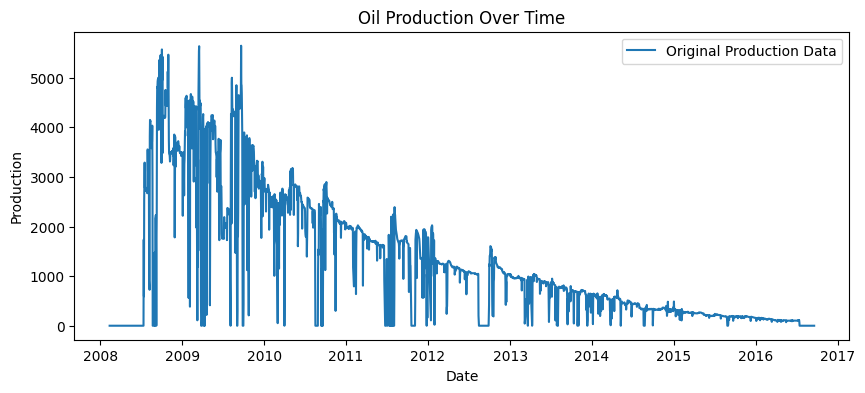

In [ ]:
# EDA
def plot_function():
    plt.figure(figsize=(10, 4))
    plt.plot(df1.index, df1['Production'], label='Original Production Data')
    plt.title('Oil Production Over Time')
    plt.xlabel('Date')
    plt.ylabel('Production')
    plt.legend()
    plt.show()
plot_function()

In [ ]:
# Feature engineering
df1['Year'] = df1.index.year
df1['Month'] = df1.index.month
df1['Day'] = df1.index.day

# Remove the WellID column
df1.drop(columns=['WellID'], inplace=True)

# Filter off some unwanted data
df1 = df1[(df1['Year'] <= 2014)&(df1['Production'] != 0)]

df1.head()

,Production,Year,Month,Day
Date,,,,
2008-07-13,1735.26,2008,7,13
2008-07-14,592.36,2008,7,14
2008-07-15,2532.21,2008,7,15
2008-07-16,3030.71,2008,7,16
2008-07-17,3288.08,2008,7,17


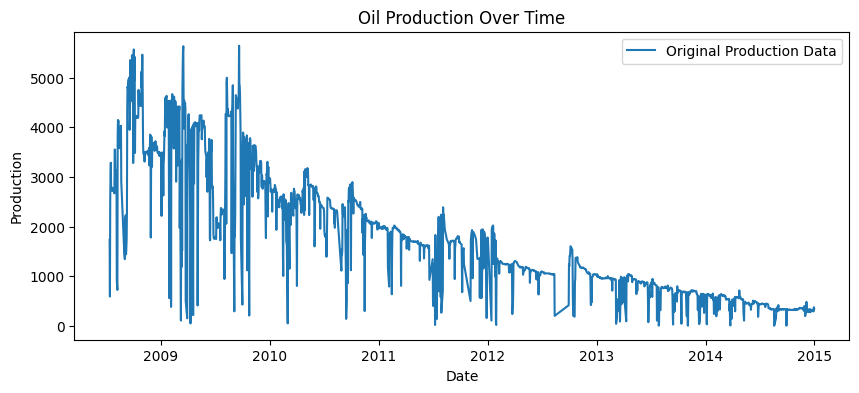

In [ ]:
plot_function()

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1['Production'].values.reshape(-1, 1))
scaled_data

array([[0.30690399],
       [0.10426466],
       [0.44820543],
       ...,
       [0.05113589],
       [0.06591408],
       [0.06197795]])

In [ ]:
import pickle
from sklearn.preprocessing import MinMaxScaler

# Fit and save the scaler on the training data
scaler_s = MinMaxScaler(feature_range=(0, 1))
scaler_s.fit(df1[['Production']].values)

# Save the scaler
with open('/content/drive/MyDrive/Colab Notebooks/well_production/models/scaler_s.pkl', 'wb') as f:
    pickle.dump(scaler_s, f)

In [ ]:
# Create time lap features
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Set time steps for Neural Network
time_steps = 10

# Create training dataset
X, y = create_dataset(scaled_data, time_steps)

In [ ]:
# Train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

split_index = int(len(df1) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]
print(X_train.shape)
print(X_test.shape)

(1733, 10)
(424, 10)


In [ ]:
y_train = y[:split_index]
y_test = y[split_index:]
print(y_train.shape)
print(y_test.shape)

(1733,)
(424,)


In [ ]:
# # Build the Neural Network model
# model1 = Sequential()
# model1.add(Dense(units=50, activation='relu', input_dim=X_train.shape[1]))
# model1.add(Dense(units=6, activation='relu'))
# model1.add(Dense(units=1, activation='linear'))

# # Compile the Model
# model1.compile(optimizer='adam', loss='mean_squared_error');

# Build the Neural Network model
model1 = Sequential()
model1.add(Input(shape=(X_train.shape[1],)))
model1.add(Dense(units=50, activation='relu'))
model1.add(Dense(units=6, activation='relu'))
model1.add(Dense(units=1, activation='linear'))
# Compile the Model
model1.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Display the model summary
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                550       
                                                                 
 dense_7 (Dense)             (None, 6)                 306       
                                                                 
 dense_8 (Dense)             (None, 1)                 7         
                                                                 
Total params: 863 (3.37 KB)
Trainable params: 863 (3.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
model1.fit(X_train, y_train, epochs=100, batch_size=32);

Epoch 1/100
55/55 [==============================] - 1s 2ms/step - loss: 0.0561
Epoch 2/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 4/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 5/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 6/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 7/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 8/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 9/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 10/100
55/55 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 11/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0080
Epoch 12/100
55/55 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 13/100
55/55 [=================

In [ ]:
# Evaluate the model
train_predict_r = model1.predict(X_train)
test_predict_r = model1.predict(X_test)


14/14 [==============================] - 0s 2ms/step


In [ ]:
# Transform the predictions back to original scale
train_predict = scaler.inverse_transform(train_predict_r)
test_predict = scaler.inverse_transform(test_predict_r)
mean_absolute_error(y_train, train_predict)

# Calculate evaluation metrics
mae = mean_absolute_error(y_train, train_predict)
mse = mean_squared_error(y_train, train_predict)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 2104.3777184300766
Mean Squared Error (MSE): 5650167.739974697
Root Mean Squared Error (RMSE): 2377.0081489079284


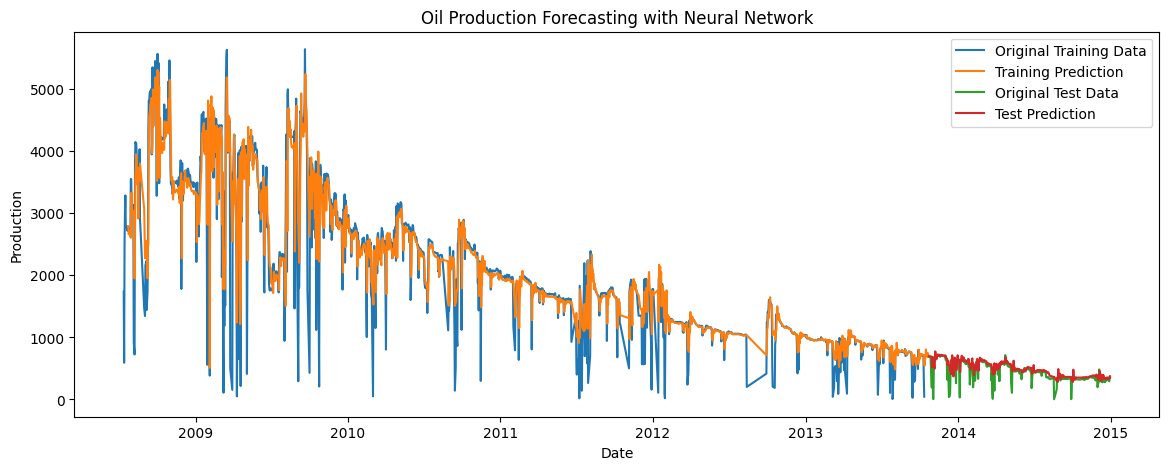

In [ ]:
# Plot the results
plt.figure(figsize=(14, 5))

# Plot training data
plt.plot(df1.index[:len(train_predict)], df1['Production'].iloc[:len(train_predict)], label='Original Training Data')
plt.plot(df1.index[time_steps:len(train_predict) + time_steps], train_predict, label='Training Prediction')

# Plot testing data
plt.plot(df1.index[len(train_predict) + (time_steps):], df1['Production'].iloc[len(train_predict) + (time_steps):], label='Original Test Data')
plt.plot(df1.index[len(train_predict) + (time_steps):], test_predict, label='Test Prediction')

plt.title('Oil Production Forecasting with Neural Network')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame for training data
df_results = pd.DataFrame({'Production': df1['Production'],
                         'Prediction': np.concatenate([np.full(10, np.nan), train_predict.reshape(-1), test_predict.reshape(-1)])
                        }, index=df1.index)
df_results.tail(11)

,Production,Prediction
Date,,
2014-12-21,319.65,339.053833
2014-12-22,305.35,345.311249
2014-12-23,312.70,346.623657
2014-12-24,312.55,356.659821
2014-12-25,318.56,332.841980
2014-12-26,326.73,332.228912
2014-12-27,314.02,349.540894
2014-12-28,319.75,347.009552
2014-12-29,292.71,342.712677


In [ ]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Plot training data
fig.add_trace(go.Scatter(x=df_results.index[:split_index],
                         y=df_results['Production'][:split_index],
                         mode='lines',
                         name='Original Training Data'))

fig.add_trace(go.Scatter(x=df_results.index[time_steps:split_index + time_steps],
                         y=df_results['Prediction'][time_steps:split_index + time_steps],
                         mode='lines',
                         name='Training Prediction'))

# Update layout
fig.update_layout(title='Oil Production Forecasting with Neural Network',
                  xaxis_title='Date',
                  yaxis_title='Production',
                  showlegend=True,
                  template='plotly_dark')

# Show the plot
fig.show()

In [ ]:
# Plot testing data

# Create the figure
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=df_results.index[split_index + time_steps:],
                         y=df_results['Production'][split_index + time_steps:],
                         mode='lines',
                         name='Original Test Data'))

fig2.add_trace(go.Scatter(x=df_results.index[split_index + time_steps:],
                         y=df_results['Prediction'][split_index + time_steps:],
                         mode='lines',
                         name='Test Prediction'))
# Update layout
fig2.update_layout(title='Oil Production Forecasting with Neural Network',
                  xaxis_title='Date',
                  yaxis_title='Production',
                  showlegend=True,
                  template='plotly_dark')

In [ ]:
# Forecast into the future
future_dates = [df1.index[-1] + timedelta(days=i) for i in range(0, 30)]  # Forecasting for the next 6 months
future_dates = pd.to_datetime(future_dates)

# Create input for forecasting
input_data = df_results['Production'].values[-time_steps:].reshape(1, -1)
forecast = []

# Generate future predictions
for i in range(30):
    predicted_value = model1.predict(input_data)
    forecast.append(predicted_value[0, 0])

    input_data = np.append(input_data[:, 1:], predicted_value.reshape(1, 1), axis=1)

# Transform the forecasted data back to the original scale
# forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 [==============================] - 0s 20ms/step


In [ ]:
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])
forecast_df.index.name = 'Date'
forecast_df.head()

,Forecast
Date,
2014-12-31,313.876434
2015-01-01,286.084259
2015-01-02,218.517563
2015-01-03,48.381260
2015-01-04,47.465466


In [ ]:
# line plot using Plotly

fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['Forecast'], mode='lines', name='Forecasted Production'))

fig.update_layout(title='Oil Production Forecast for the Next 6 Months',
                  xaxis_title='Date',
                  yaxis_title='Production',
                  showlegend=True,
                  template='plotly_dark')

# Show the plot
fig.show()

In [ ]:
# Model evaluation
# predictions = model.predict(X_train)
mse = mean_squared_error(y_train, train_predict_r)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0056012376723427884


In [ ]:
import pickle

model1.save('/content/drive/MyDrive/Colab Notebooks/well_production/models/ann_model.h5')


# Load the model using load_model
model1_loaded = load_model('/content/drive/MyDrive/Colab Notebooks/well_production/models/ann_model.h5')